# CareerVillage knowledge graph analysis with node embeddings

> # 1. Load data

#### We shall load the data CareerVillage.

In [34]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from collections import Counter

In [35]:
# Extracting the files
files = os.listdir("C:\\Users\\vansh\\Downloads\\data-science-for-good-careervillage")
files

['answers.csv',
 'answer_scores.csv',
 'comments.csv',
 'emails.csv',
 'groups.csv',
 'group_memberships.csv',
 'matches.csv',
 'professionals.csv',
 'questions.csv',
 'question_scores.csv',
 'school_memberships.csv',
 'students.csv',
 'tags.csv',
 'tag_questions.csv',
 'tag_users.csv']

#### Here, we are extracting the dimensions of each csv file present inside our directory.

In [36]:
import os
import pandas as pd

data_parts = {}
directory = "C:\\Users\\vansh\\Downloads\\data-science-for-good-careervillage"

for file_name in os.listdir(directory):
    if file_name.endswith(".csv"):
        file_id = file_name.split(".")[0]
        file_path = os.path.join(directory, file_name)
        data_parts[file_id] = pd.read_csv(file_path)
        print(file_id)
        print(data_parts[file_id].shape)


answers
(51123, 5)
answer_scores
(51138, 2)
comments
(14966, 5)
emails
(1850101, 4)
groups
(49, 2)
group_memberships
(1038, 2)
matches
(4316275, 2)
professionals
(28152, 5)
questions
(23931, 5)
question_scores
(23928, 2)
school_memberships
(5638, 2)
students
(30971, 3)
tags
(16269, 2)
tag_questions
(76553, 2)
tag_users
(136663, 2)


> # 2.Build knowledge graph from CareerVillage data

#### We are now going to assign nodes and edges based information into our dataset and apply it with the help of NetworkX.

In [37]:
def add_nodes(G, df, col, type_name):
    """Add entities to G from the 'col' column of the 'df' DataFrame. The new nodes are annotated with 'type_name' label."""
    nodes = list(df[~df[col].isnull()][col].unique())
    G.add_nodes_from([(n,dict(type=type_name)) for n in nodes])
    print("Nodes (%s,%s) were added" % (col, type_name))

def add_links(G, df, col1, col2, type_name):
    """Add links to G from the 'df' DataFrame. The new edges are annotated with 'type_name' label."""
    df_tmp = df[(~df[col1].isnull()) & (~df[col2].isnull())]
    links = list(zip(df_tmp[col1],df_tmp[col2]))
    G.add_edges_from([(src, trg, dict(type=type_name)) for src, trg in links])
    print("Edges (%s->%s,%s) were added" % (col1, col2, type_name))

In [38]:
G = nx.DiGraph()

## i.) Nodes

The vertices of the knowledge graph consists of the following entities:
- answers
- questions
- comments
- students
- professionals
- industries
- schools
- tags
- user groups
- group types

In [39]:
add_nodes(G, data_parts["answers"], "answers_id", "answer")
add_nodes(G, data_parts["comments"], "comments_id", "comment")
add_nodes(G, data_parts["groups"], "groups_id", "group")
add_nodes(G, data_parts["groups"], "groups_group_type", "group_type")
add_nodes(G, data_parts["professionals"], "professionals_id", "professional")
add_nodes(G, data_parts["professionals"], "professionals_industry", "industry")
add_nodes(G, data_parts["questions"], "questions_id", "question")
add_nodes(G, data_parts["school_memberships"], "school_memberships_school_id", "school")
add_nodes(G, data_parts["students"], "students_id", "student")
add_nodes(G, data_parts["tags"], "tags_tag_id", "tag")

Nodes (answers_id,answer) were added
Nodes (comments_id,comment) were added
Nodes (groups_id,group) were added
Nodes (groups_group_type,group_type) were added
Nodes (professionals_id,professional) were added
Nodes (professionals_industry,industry) were added
Nodes (questions_id,question) were added
Nodes (school_memberships_school_id,school) were added
Nodes (students_id,student) were added
Nodes (tags_tag_id,tag) were added


## ii.) Edges

In [40]:
add_links(G, data_parts["answers"], "answers_id", "answers_question_id", "question")
add_links(G, data_parts["answers"], "answers_id", "answers_author_id", "author")
add_links(G, data_parts["comments"], "comments_id", "comments_parent_content_id", "parent_content")
add_links(G, data_parts["comments"], "comments_id", "comments_author_id", "author")
add_links(G, data_parts["group_memberships"], "group_memberships_user_id", "group_memberships_group_id", "member")
add_links(G, data_parts["groups"], "groups_id", "groups_group_type", "type")
add_links(G, data_parts["professionals"], "professionals_id", "professionals_industry", "type")
add_links(G, data_parts["questions"], "questions_id", "questions_author_id", "author")
add_links(G, data_parts["school_memberships"], "school_memberships_user_id", "school_memberships_school_id", "member")
add_links(G, data_parts["tag_questions"], "tag_questions_question_id", "tag_questions_tag_id", "tag")
add_links(G, data_parts["tag_users"], "tag_users_user_id", "tag_users_tag_id", "follow")

Edges (answers_id->answers_question_id,question) were added
Edges (answers_id->answers_author_id,author) were added
Edges (comments_id->comments_parent_content_id,parent_content) were added
Edges (comments_id->comments_author_id,author) were added
Edges (group_memberships_user_id->group_memberships_group_id,member) were added
Edges (groups_id->groups_group_type,type) were added
Edges (professionals_id->professionals_industry,type) were added
Edges (questions_id->questions_author_id,author) were added
Edges (school_memberships_user_id->school_memberships_school_id,member) were added
Edges (tag_questions_question_id->tag_questions_tag_id,tag) were added
Edges (tag_users_user_id->tag_users_tag_id,follow) were added


## iii.) Location information

Location information of users and professionals are preprocessed before I add it to the knowledge graph. I tried to extract **city / state / country** hierarchy from locations were it was provided. In this case I created different levels for locations: cities, states/regions and countries.

In [41]:
students = data_parts["students"]
profs = data_parts["professionals"]
students = students[~students["students_location"].isnull()]
profs = profs[~profs["professionals_location"].isnull()]

In [42]:
locs1 = list(students["students_location"])
locs2 = list(profs["professionals_location"])
locs = [loc.lower() for loc in locs1+locs2]
locs_unique = list(set(locs))

In [43]:
print(nx.info(G))

DiGraph with 170730 nodes and 400645 edges


C:\Users\vansh\AppData\Local\Temp\ipykernel_29300\2606185536.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


#### Most common locations:

In [44]:
cnt = Counter(locs)
cnt.most_common()[:10]

[('new york, new york', 2650),
 ('bengaluru, karnataka, india', 1284),
 ('los angeles, california', 1280),
 ('boston, massachusetts', 1271),
 ('houston, texas', 1032),
 ('san francisco, california', 975),
 ('chicago, illinois', 920),
 ('california, california', 894),
 ('greater new york city area', 745),
 ('atlanta, georgia', 738)]

#### Preprocess location information:

In [45]:
new_edges = []
new_nodes = []
for loc in locs_unique:
    loc_hierarchy = loc.split(", ")
    loc_nodes = [] # due to city name duplicates in the world
    k = len(loc_hierarchy)
    for i in range(k):
        loc_nodes.append('_'.join(loc_hierarchy[i:]))
    new_nodes += loc_nodes
    loc_links = [(loc_nodes[i],loc_nodes[i+1], dict(type="location"))  for i in range(k-1)]
    new_edges += loc_links
new_nodes = list(set(new_nodes))
new_nodes = [(n, dict(type="location")) for n in new_nodes]

#### Add location nodes to the graph

- the 3 level of nodes are added
- connections between cities -> regions, regions -> contires are added

In [46]:
G.add_nodes_from(new_nodes)
G.add_edges_from(new_edges)
print(len(new_edges), len(new_nodes))

7253 7160


#### Examples:

- Locations that are immediate in-neighbors of entity United Kingdom (e.g.: England, Scotland etc.).

In [47]:
list(G.in_edges("united kingdom"))[:5]

[('england_united kingdom', 'united kingdom'),
 ('scotland_united kingdom', 'united kingdom'),
 ('wales_united kingdom', 'united kingdom'),
 ('portsmouth_united kingdom', 'united kingdom'),
 ('northern ireland_united kingdom', 'united kingdom')]

- Locations that are in-neighbors of entity England

In [48]:
list(G.in_edges("england_united kingdom"))[:5]

[('mildenhall_england_united kingdom', 'england_united kingdom'),
 ('leeds_england_united kingdom', 'england_united kingdom'),
 ('liverpool_england_united kingdom', 'england_united kingdom'),
 ('nottingham_england_united kingdom', 'england_united kingdom'),
 ('derby_england_united kingdom', 'england_united kingdom')]

#### Link users to the first level of locations:

In [49]:
students["students_location"] = students["students_location"].apply(lambda x: "_".join(x.lower().split(", ")))
profs["professionals_location"] = profs["professionals_location"].apply(lambda x: "_".join(x.lower().split(", ")))

C:\Users\vansh\AppData\Local\Temp\ipykernel_29300\1738426549.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  students["students_location"] = students["students_location"].apply(lambda x: "_".join(x.lower().split(", ")))
C:\Users\vansh\AppData\Local\Temp\ipykernel_29300\1738426549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profs["professionals_location"] = profs["professionals_location"].apply(lambda x: "_".join(x.lower().split(", ")))


In [50]:
add_links(G, students, "students_id", "students_location", "location")
add_links(G, profs, "professionals_id", "professionals_location", "location")

Edges (students_id->students_location,location) were added
Edges (professionals_id->professionals_location,location) were added


## iv.) Clean and encode knowledge graph

In [58]:
def encode_graph(G):
    """Encode the nodes of the network into integers"""
    nodes = [(n,d.get("type",None)) for n, d in G.nodes(data=True)]
    nodes_df = pd.DataFrame(nodes, columns=["id","type"]).reset_index()
    node2idx = dict(zip(nodes_df["id"],nodes_df["index"]))
    edges = [(node2idx[src], node2idx[trg], d.get("type",None)) for src, trg, d in G.edges(data=True)]
    edges_df = pd.DataFrame(edges, columns=["src","trg","type"])
    return nodes_df, edges_df

#### Remove isolated nodes

In [59]:
print(G.number_of_nodes(), G.number_of_edges())
G.remove_nodes_from(list(nx.isolates(G)))
print(G.number_of_nodes(), G.number_of_edges())

174181 461369
174181 461369


#### Encode the nodes to have integer identifiers

In [60]:
nodes_df, edges_df = encode_graph(G)
len(nodes_df), len(edges_df)

(174181, 461369)

#### Node information summary

In [61]:
print(nodes_df.head())
print(nodes_df["type"].value_counts())
nodes_df.to_csv("knowledge_graph_nodes.csv", index=False)

   index                                id    type
0      0  4e5f01128cae4f6d8fd697cec5dca60c  answer
1      1  ada720538c014e9b8a6dceed09385ee3  answer
2      2  eaa66ef919bc408ab5296237440e323f  answer
3      3  1a6b3749d391486c9e371fbd1e605014  answer
4      4  5229c514000446d582050f89ebd4e184  answer
answer          51123
student         29460
professional    27819
question        23931
comment         14966
tag             14404
location         7160
school           2706
industry         2470
group              49
group_type          7
Name: type, dtype: int64


#### Edge information summary

In [62]:
print(edges_df.head())
print(edges_df["type"].value_counts())
edges_df[["src","trg"]].to_csv("knowledge_graph_edges.csv", index=False, header=False, sep=" ")

   src    trg      type
0    0  96434  question
1    0  68352    author
2    1  96435  question
3    1  83417    author
4    2  96435  question
follow            135907
author             90020
tag                76553
location           60724
question           51123
type               25625
parent_content     14966
member              6451
Name: type, dtype: int64


# 3. Node2Vec

In [63]:
edge_list = list(zip(edges_df["src"],edges_df["trg"]))
edge_list[:5]

[(0, 96434), (0, 68352), (1, 96435), (1, 83417), (2, 96435)]

In [64]:
KG = nx.Graph(edge_list)
KG.number_of_nodes(), KG.number_of_edges()

(174181, 461369)

#### NOTE: We will analyse only the greatest (weakly) connected component of our knowledge graph.

In [65]:
largest_cc = max(nx.connected_components(KG), key=len)
KG = nx.subgraph(KG, largest_cc)
KG.number_of_nodes(), KG.number_of_edges()

(173933, 461225)

In [29]:
!pip install node2vec

**In this work I use the Python3 implementation of [node2vec](https://github.com/eliorc/node2vec).**

- First we generate random walks starting from each node of the knowledge graph by initializing the *Node2Vec* object
- Then we optimize node representations with the *fit()* method

In [66]:
%%time
from node2vec import Node2Vec
n2v_obj = Node2Vec(KG, dimensions=10, walk_length=5, num_walks=10, p=1, q=1, workers=1)

Computing transition probabilities:   0%|          | 0/173933 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [03:33<00:00, 21.31s/it]


CPU times: total: 20min 11s
Wall time: 50min 30s


In [67]:
zz%%time
n2v_model = n2v_obj.fit(window=3, min_count=1, batch_words=4)

CPU times: total: 2min 48s
Wall time: 15min 18s


# 4. Visualization of node embeddings

I trained Node2Vec to map every node of the knowledge graph into a 10 dimensional Euclidean space. In order to visualize the results in 2 dimension I applied the [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) dimensionality reduction algorithm.

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def get_embeddings(model, nodes):
    """Extract representations from the node2vec model"""
    embeddings = [list(model.wv.get_vector(n)) for n in nodes]
    embeddings = np.array(embeddings)
    print(embeddings.shape)
    return embeddings

def dim_reduction(embeddings, labels, frac=None, tsne_obj=TSNE(n_components=2)):
    """Dimensionality reduction with t-SNE. Sampling random instances is supported."""
    N = len(embeddings)
    print(N)
    if frac != None:
        idx = np.random.randint(N, size=int(N*frac))
        X = embeddings[idx,:]
        X_labels = [labels[i] for i in idx]
    else:
        X = embeddings
        X_labels = labels
    X_embedded = tsne_obj.fit_transform(X)
    print("t-SNE object was trained on %i records!" % X.shape[0])
    print(X_embedded.shape)
    return X_embedded, X_labels

def visu_embeddings(X_embedded, X_labels=None, colors = ['r','b']):
    if X_labels != None:
        label_map = {}
        for i, l in enumerate(usr_tsne_lab):
            if not l in label_map:
                label_map[l] = []
            label_map[l].append(i)
        fig, ax = plt.subplots(figsize=(15,15))
        for i, lab in enumerate(label_map.keys()):
            print(lab)
            idx = label_map[lab]
            x = list(X_embedded[idx,0])
            y = list(X_embedded[idx,1])
            #print(len(x),len(y))
            ax.scatter(x, y, c=colors[i], label=lab, alpha=0.5, edgecolors='none')
        plt.legend()
    else:
        plt.figure(figsize=(15,15))
        x = list(X_embedded[:,0])
        y = list(X_embedded[:,1])
        plt.scatter(x, y, alpha=0.5)

In [93]:
stud_users = list(nodes_df[nodes_df["type"] == "student"]["index"])
prof_users = list(nodes_df[nodes_df["type"] == "professional"]["index"])
print(len(stud_users), len(prof_users))
stud_users = list(set(stud_users).intersection(set(KG.nodes())))
prof_users = list(set(prof_users).intersection(set(KG.nodes())))
print(len(stud_users), len(prof_users))
stud_users = [str(item) for item in stud_users]
prof_users = [str(item) for item in prof_users]

29460 27819
29378 27781


## a.) User embeddings with t-SNE dimensionality reduction

In [94]:
users = stud_users + prof_users
usr_emb = get_embeddings(n2v_model, users)
usr_labs = ['student'] * len(stud_users) +  ['professional'] * len(prof_users)

(57159, 10)


### I visualize only a randomly selected 50% of the users for clarity

In [95]:
%%time
usr_tsne_emb, usr_tsne_lab = dim_reduction(usr_emb, usr_labs, frac=0.5)

57159
t-SNE object was trained on 28579 records!
(28579, 2)
CPU times: total: 8min 35s
Wall time: 4min 23s


professional
student


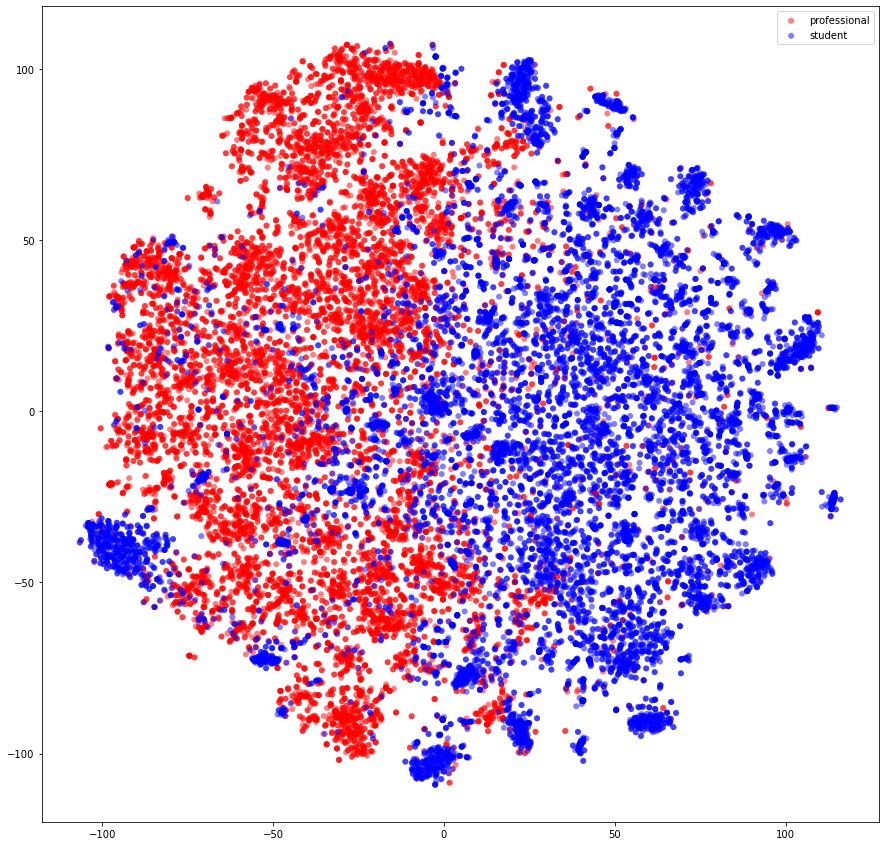

In [96]:
visu_embeddings(usr_tsne_emb, usr_tsne_lab)

# Conclusion: 

### It can be observed that students and professionals do not have much in common throughout all the different factors. 

#### Let's us now consider similarity based on location of professionals and students.

In [75]:
# After adding nodes and edges for locations, extract location information for students and professionals
student_locations = students["students_location"].tolist()
prof_locations = profs["professionals_location"].tolist()

In [76]:
# Determine whether the location of each node (student or professional) is the same or different
location_labels = []
for node in G.nodes:
    if node in stud_users:
        if G.nodes[node]["type"] == "student":
            if G.nodes[node]["location"] in student_locations:
                location_labels.append("Same Location")
            else:
                location_labels.append("Different Location")
    elif node in prof_users:
        if G.nodes[node]["type"] == "professional":
            if G.nodes[node]["location"] in prof_locations:
                location_labels.append("Same Location")
            else:
                location_labels.append("Different Location")

In [77]:
# Modify the visu_embeddings function to color-code nodes based on their location similarity or difference
def visu_embeddings(X_embedded, X_labels=None, colors=['r', 'b']):
    if X_labels is not None:
        fig, ax = plt.subplots(figsize=(15, 15))
        for i, lab in enumerate(set(X_labels)):
            idx = [j for j, x in enumerate(X_labels) if x == lab]
            x = list(X_embedded[idx, 0])
            y = list(X_embedded[idx, 1])
            ax.scatter(x, y, c=colors[i], label=lab, alpha=0.5, edgecolors='none')
        plt.legend()
    else:
        plt.figure(figsize=(15, 15))
        x = list(X_embedded[:, 0])
        y = list(X_embedded[:, 1])
        plt.scatter(x, y, alpha=0.5)

In [98]:
assert len(usr_emb) == len(location_labels)
usr_tsne_emb1, usr_tsne_lab1 = dim_reduction(usr_emb, location_labels, frac=0.5)

57159
t-SNE object was trained on 28579 records!
(28579, 2)


professional
student


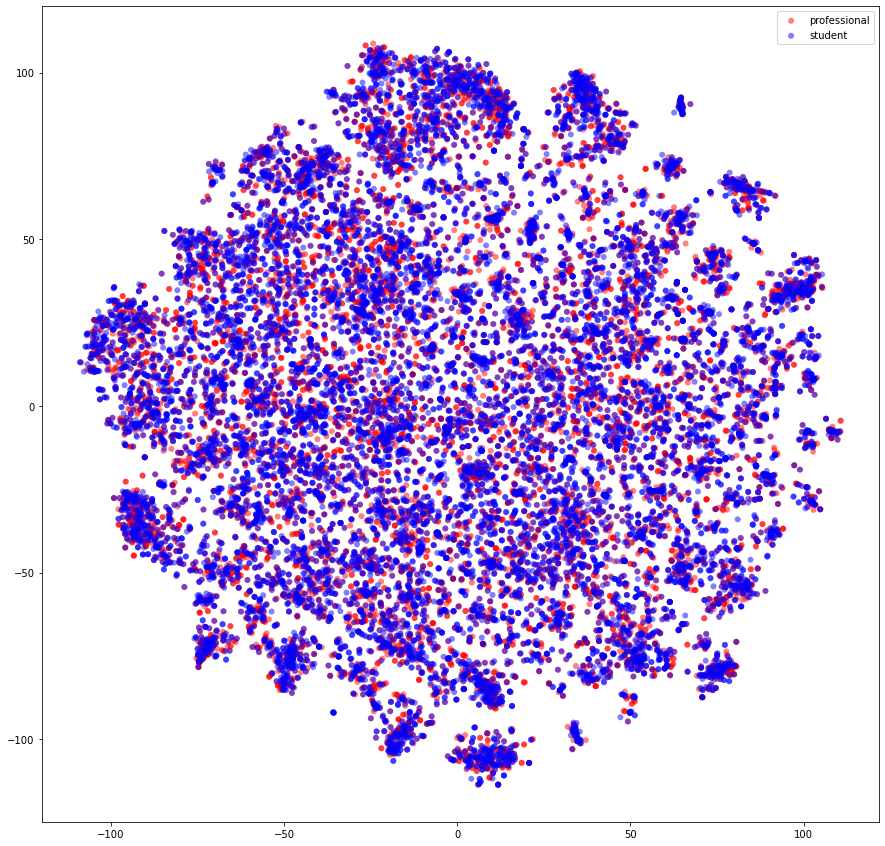

In [100]:
# Visualize the embeddings with location information
visu_embeddings(usr_tsne_emb1, usr_tsne_lab1)

# Conclusion:

### However, we can observe that the locations are very similar of both the professionals and students. Hence, this analytics gives us a confirmation that when students from a specific location connect with a professional for help, the professional is most likely to be from the same place.

#### This proves to be beneficial because the career importance pie charts varies from location to location. Suppose, if a person from India, Bengaluru connects as a student to inquire about an IT job. A professional only from those locations (sometimes irrespective of their field) can be helpful in guiding them about the ooportunities and growth.